## 題目：共享單車需求預測
* 資料來源：下載自[Kaggle](https://www.kaggle.com/c/bike-sharing-demand)

* 資料說明：本項目數據來自華盛頓一家共享單車公司，數據顯示了2011年至2012年共享單車的使用情況，數據記錄了包括時間，天氣，節假日等信息。

* 目的：結合歷史騎行數據和天氣等數據，預測美國華盛頓的共享單車租賃需求。
* 使用演算法：隨機森林 Random Forest

* 撰寫思路：
1. 讀取數據
2. 數據處理
3. 探索性分析
4. 特徵值選擇
5. 建構預測模型
6. 產生預測結果



In [ ]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import mpltw #matplotlib 中文字體套件
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score
#!pip install mpltw
warnings.filterwarnings('ignore')
# set up to view all the info of the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 1. 讀取數據

In [ ]:
train =  pd.read_csv('/content/drive/MyDrive/My_Dataset /kaggle-bike-sharing-demand/train.csv')
test =  pd.read_csv('/content/drive/MyDrive/My_Dataset /kaggle-bike-sharing-demand/test.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


#### 特徵值說明
數據集共有12個特徵。  
datetime：時間。年月日小時格式  
season：季節。 1：春天；2：夏天；3：秋天；4：冬天  
holiday：是否節假日。 0：否；1：是  
workingday：是否工作日。 0：否；1：是  
weather：天氣。 1：晴天；2：陰天；3：小魚或小雪；4：惡劣天氣  
temp：實際溫度  
atemp：體感溫度  
humidity：濕度  
windspeed：風速  
casual：未註冊用戶租車數量  
registered：註冊用戶租車數量  
count：總租車數量    

可拆分為以下三類：  
* 時間類特徵：datetime，season，holiday，workingday 

* 天氣類特徵：weather，temp，atemp，humidity，windspeed 

* 目標類特徵：causal，registered，count 

In [ ]:
#Check basic info of the data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


數據沒有缺失值，因此不須額外處理

### 2. 數據處理

使用describe看Train資料分布狀況

In [ ]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


* 我們發現最後右邊的欄位count中的50百分位數為145, 75百分位數為284以及 max值為977相差非常巨大，也可以發現count的標準差很大。因此可以判斷有Outlier。
* 我們可以使用最簡單的超出三倍標準差的統計概念將這些Outlier先去掉，避免對Model造成影響，去掉Outlier之後的預測分數照理來說也會明顯提升。

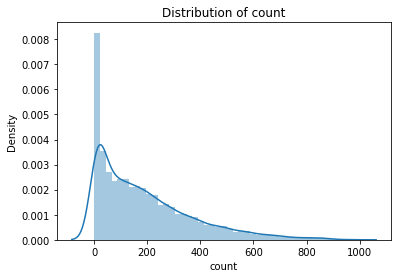

In [ ]:
# 繪製租賃額分佈圖
sns.distplot(train['count'])
plt.title('Distribution of count')
plt.show()

* 整體的分佈傾斜比較嚴重，需要處理一下，以便於最後不會Overfitting。  
* 處理方法：將3個標準差以外的數據排除，然後對count做log變換，並查看變換後的分佈。

Text(0.5, 0, '租賃量（count）')

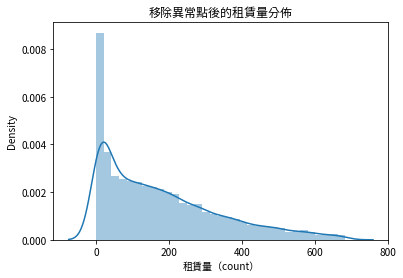

In [ ]:
#排除3個標準差以外的數據
train=train[np.abs(train['count']-train['count'].mean())<=3*train['count'].std()]
fig=plt.figure()
plt.subplot(1,1,1)
sns.distplot(train['count'])
plt.title('移除異常點後的租賃量分佈')
plt.xlabel('租賃量（count）')

Text(0.5, 1.0, 'log變換後的count分佈')

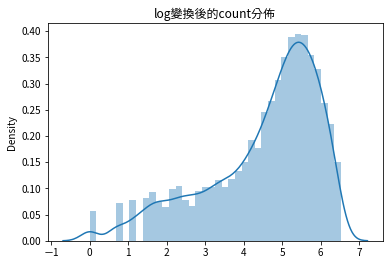

In [ ]:
#對數變換
y=train['count'].values
y_log=np.log(y)
sns.distplot(y_log)
plt.title('log變換後的count分佈')

我們可以看到：對數變換後的數據，圖形的傾斜沒有那麼嚴重，差異也變小了。

#### 數據清洗

接下來要將時間處理成讓Random forest可以分析的格式，我們將時間拆成日期、小時、年、星期幾、月份的欄位（日期之後不會用到主要是用來算星期幾以及月份）。由於Train跟Test的資料都要做這樣的處理，因此我們先把Train, Test Data合併後一起處理。

In [ ]:
def Data_cleaning(combined):
  combined['year']=combined.datetime.apply(lambda x:x.split()[0].split('-')[0]).astype('int')
  combined['month']=combined.datetime.apply(lambda x:x.split()[0].split('-')[1]).astype('int')
  combined['date']=combined.datetime.apply(lambda x:x.split()[0])
  combined['hour']=combined.datetime.apply(lambda x:x.split()[1].split(':')[0]).astype('int')
  combined['weekday']=combined.date.apply( lambda x : datetime.strptime(x,'%Y-%m-%d').isoweekday())
  return combined
  
combined=train.append(test)
combined=Data_cleaning(combined)

In [ ]:
combined.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,date,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011,1,2011-01-01,0,6
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011,1,2011-01-01,1,6
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011,1,2011-01-01,2,6
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011,1,2011-01-01,3,6
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011,1,2011-01-01,4,6


### 3. 探索性分析

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '時間對租賃的影響')]

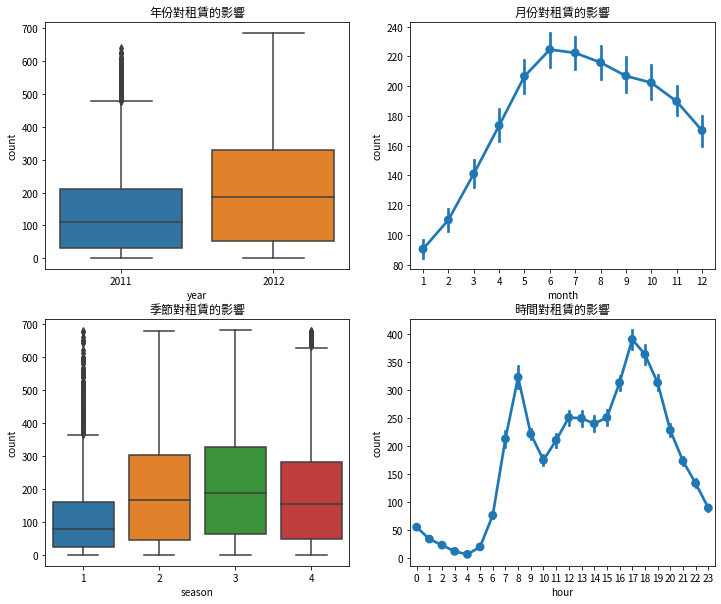

In [ ]:
train=Data_cleaning(train)
#每個特徵對租借量的影響
fig,axes=plt.subplots(2,2)
fig.set_size_inches(12,10)
#(1) 時間維度——年份
sns.boxplot(train['year'],train['count'],ax=axes[0,0])
#(2) 時間維度——月份
sns.pointplot(train['month'],train['count'],ax=axes[0,1])
#(3) 時間維度——季節
sns.boxplot(train['season'],train['count'],ax=axes[1,0])
#(4) 時間維度——時間（小時）
sns.pointplot(train['hour'],train['count'],ax=axes[1,1])
axes[0,0].set(xlabel='year',title='年份對租賃的影響')
axes[0,1].set(xlabel='month',title='月份對租賃的影響')
axes[1,0].set(xlabel='season',title='季節對租賃的影響')
axes[1,1].set(xlabel='hour',title='時間對租賃的影響')

#### 分析說明
* "年份對租賃量的影響"圖：2012年的租賃量比2011年的高，說明隨著時間的推移，共享單車逐漸被更多的人接受，使用人數也越來越多。

* “月份對租賃量的影響圖”：月份對租賃量的影響顯著，從1月份開始使用人數逐漸增多，到6月份達到頂峰，隨後到10月份急劇下降，這明顯和季節有關。

* “季節對租賃量的影響圖”：夏季和秋季騎車人數較多，並在秋季（天氣適宜時）達到頂峰。但由於季節和月份的影響基本重合，且月份更加詳細，因此建立模型時選取月份特徵，去掉季節特徵。

* “時間對租賃量的影響圖”：通過圖形發現，每天有2個高峰期，分別是早上8點左右和下午17點左右，正好是工作日的上下班高峰。因此可以聯想到節假日和星期對租賃量的影響。
 

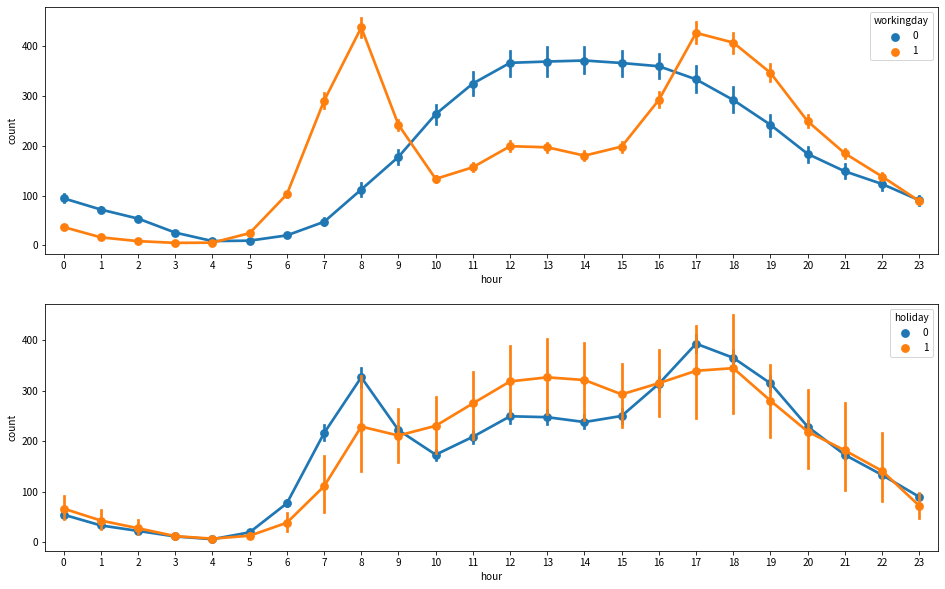

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(16, 10))
sns.pointplot(train['hour'],train['count'],hue=train['workingday'],ax=plt.subplot(2,1,1))
sns.pointplot(train['hour'],train['count'],hue=train['holiday'],ax=plt.subplot(2,1,2))

可以看出，工作日早晚上班高峰期租借量高，其餘時間租借量低；節假日中午及午後租借量較高。符合人們的的出行用車規律。

#### 從天氣特徵分析

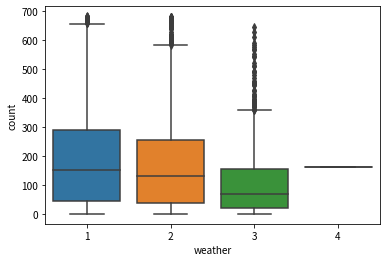

In [ ]:
# 天气的影响
sns.boxplot(train['weather'],train['count'])

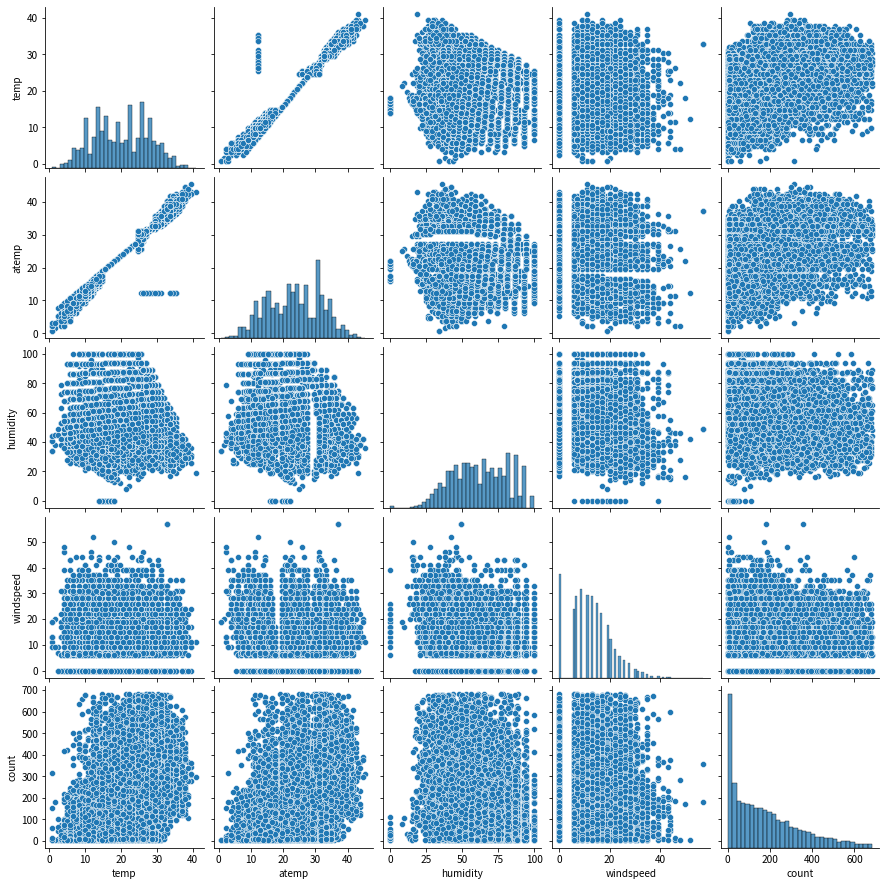

In [ ]:
#溫度、濕度、風速的影響
sns.pairplot(train[['temp', 'atemp', 'humidity', 'windspeed', 'count']])

作出多個連續變量之間的相關圖時，可以比較任意兩個變量之間的相關關係。圖中temp和atemp的形狀大體相似，因此可以在後續建模中用temp，刪除掉atemp。

#### 相關性分析

* 為了更加直觀地展現所有特徵之間的影響，作相關係數熱力圖：

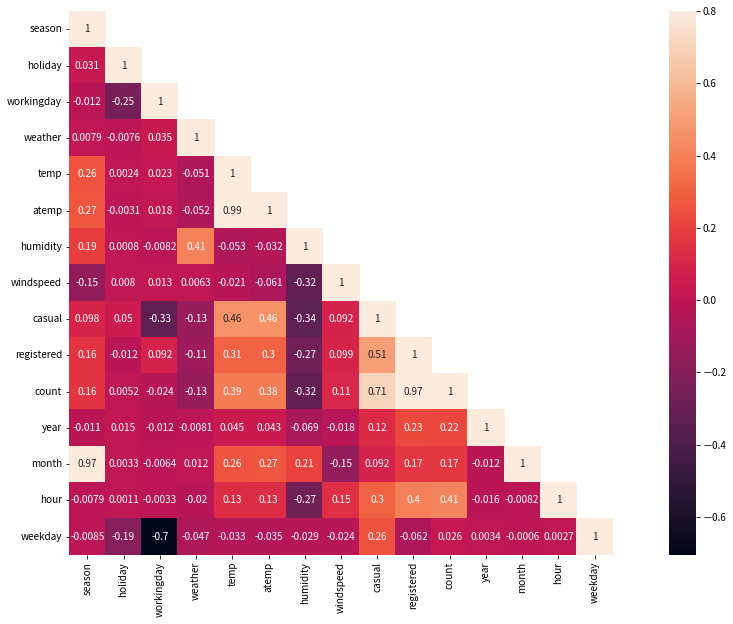

In [ ]:
correlation = train.corr()
mask = np.array(correlation)
mask[np.tril_indices_from(mask)] = False

fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(correlation, mask=mask,vmax=.8, square=True,annot=True)


* count 和 registered、casual高度正相關，相關係數分別為0.7 與0.97。因為 count = casual + registered ，所以這個正相關和預期相符。
* count 和 temp 正相關，相關係數為 0.39。一般來說，氣溫過低人們不願意騎車出行。  
* count 和 humidity（濕度）負相關，濕度過大的天氣不適宜騎車。當然考慮濕度的同時也應該考慮溫度。 
* windspeed似乎對租車人數影響不大（0.1），但我們也應該考慮到極端大風天氣出現頻率應該不高。風速在正常範圍內波動應該對人們租車影響不大。
* 可以看出特徵值對租賃數量的影響力度為：時段>溫度>濕度>年份>月份>季節>天氣等級>風速>星期幾>是否工作日>是否假日

### 4. 特徵值選擇
根據前面的觀察我們在這裡將：  
時段（hour）、溫度（temp）、濕度（humidity）、年份（year）、月份（month）、季節（season）、天氣等級（weather）、風速（windspeed）、星期幾（weekday）、是否工作日（workingday）、是否假日（holiday），11項作為特徵值。


### 5. 建構模型
由於隨機森林使用二分類，所以將多類別型數據使用one-hot轉化成多個二分型類別。

In [ ]:
month_one_hot = pd.get_dummies(combined['month'], prefix='month')
year_one_hot = pd.get_dummies(combined['year'], prefix='year')
season_one_hot = pd.get_dummies(combined['season'], prefix='season')
weather_one_hot = pd.get_dummies(combined['weather'], prefix='weather')
combined_one_hot = pd.concat([combined,month_one_hot,year_one_hot,season_one_hot,weather_one_hot],axis=1)

In [ ]:
#分開訓練集和測試集
train_df = combined_one_hot.loc[combined['count'].isnull() == False]
test_df = combined_one_hot.loc[combined['count'].isnull() == True]
datetime_col = test_df['datetime']
ylables = train_df['count']
#對數轉換
y_log= np.log(ylables)

In [ ]:
# 刪除多餘特徵值
drop_columns = ['casual','count','datetime','registered','date','atemp','month','year','season','weather']
train_df = train_df.drop(drop_columns,axis=1)
test_df = test_df.drop(drop_columns,axis=1)

#### 我們運用交叉驗證法做參數最佳化

In [ ]:
# 訓練集轉換為訓練數據和驗證數據
x_train,x_test,y_train,y_test=train_test_split(train_df,y_log,test_size=0.2)
print(x_train.shape)
print(x_test.shape)

(8531, 29)
(2133, 29)


In [ ]:
# 隨機森林的參數：決策樹的數量、每個樹的深度
rf = RandomForestClassifier()
# 交叉驗證
param = {"n_estimators":[100,200],"max_depth":[5,8,10]}
gc = GridSearchCV(rf,param_grid=param,cv=5)
gc.fit(x_train,y_train.astype('int'))
print("最佳參數模型：",gc.best_params_)

最佳參數模型： {'max_depth': 10, 'n_estimators': 200}


將最佳化後參數應用到模型中

In [ ]:
rf_true = RandomForestClassifier(n_estimators=200,max_depth=10,random_state=10,min_samples_split=10)
rf_true.fit(x_train,y_train.astype('int'))
predict_final = rf_true.predict(x_test)
print("測試集上的準確率:",rf_true.score(x_test,y_test.astype('int')))
print("測試集上的召回率:",r2_score(y_test,predict_final))

測試集上的準確率: 0.6104078762306611
測試集上的召回率: 0.7234974287304208


模型準確率比較低，我們可以繼續調整參數進行驗證，選擇最佳參數

### 6. 產生預測結果
我們來讓機器學習模型幫我們預測一批沒看過的資料；AKA測試期間資料。


In [ ]:
datas = np.exp(rf_true.predict(test_df))
final=pd.DataFrame({'datetime':datetime_col,'count':datas})
final.head()
#final.to_csv('./result_final.csv',index = False) #匯出預測結果

,datetime,count
0,2011-01-20 00:00:00,2.718282
1,2011-01-20 01:00:00,2.718282
2,2011-01-20 02:00:00,2.718282
3,2011-01-20 03:00:00,2.718282
4,2011-01-20 04:00:00,2.718282
